In [ ]:
# agglom by k across k models (4.6.20)


In [11]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
sys.path.append('/Users/lee_jollans/PycharmProjects/mdd_clustering/')
sys.path.append('/Users/lee_jollans/PycharmProjects/mdd_clustering/cv_clustering')
sys.path.append('/Users/lee_jollans/Projects/clustering_pilot/may2020_evaluation/')
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import pathlib
from scipy.cluster.hierarchy import dendrogram
from cv_clustering.mainfoldaggr import plot_dendrogram
from sklearn.manifold import TSNE
from cv_clustering.utils import colorscatter
from cv_clustering.beta_aggregate import vector_mse, get_proba, prob_from_data2
from sklearn.metrics import explained_variance_score, silhouette_score
import copy
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from numpy import savetxt
import statsmodels.api as sm
from statsmodels.formula.api import ols

sets = ["Tc", "Sc", "TSc", "Tc_tc", "Sc_sc", "TSc_tsc", "Tct_s", "Scs_s", "Tct_Scs_s", "Tct_tc_s", "Scs_sc_s", "Tct_Scs_tc_sc_s"]
setsize=np.array([82,82,150,84,84,154,82,82,150,84,84,154])
n_cv_folds = 4
n_k = 8

input_filedir = '/Users/lee_jollans/Projects/clustering_pilot/FEB_PUT/FEB_'
modstr = '_mod_ctrl_'
input_filedirn = '/Users/lee_jollans/Projects/clustering_pilot/null/MDDnull/MDD__'
modstrn = '_mod_null_'

input_filediri = '/Users/lee_jollans/Projects/clustering_pilot/IXI2/act/IXI2_'
modstri = '_mod_'
input_filedirin = '/Users/lee_jollans/Projects/clustering_pilot/IXI2/null2/IXI2_'
modstrin = '_mod_null_'

input_filedira = '/Users/lee_jollans/Projects/clustering_pilot/ALL/wspecsamp_'
modstra = '_mod_'

In [12]:
def k_clus_comp(tmp):
    allmses = np.full([len(tmp), len(tmp), tmp[0].shape[1], tmp[0].shape[1]], np.nan)
    allvarexp = np.full([len(tmp), len(tmp), tmp[0].shape[1], tmp[0].shape[1]], np.nan)
    allcorrs = np.full([len(tmp), len(tmp), tmp[0].shape[1], tmp[0].shape[1]], np.nan)
    for mf1 in range(len(tmp)):
        for mf2 in range(len(tmp)):
            if mf1 < mf2:
                for c1 in range(tmp[0].shape[1]):
                    for c2 in range(tmp[0].shape[1]):
                        a = tmp[mf1][:, c1]
                        b = tmp[mf2][:, c2]
                        allmses[mf1, mf2, c1, c2] = vector_mse(a, b)
                        allcorrs[mf1, mf2, c1, c2] = np.corrcoef(a, b)[0, 1] ** 2
                        ttt=(explained_variance_score(a, b) + explained_variance_score(b,a)) / 2
                        allvarexp[mf1, mf2, c1, c2] = ttt
                        allvarexp[mf2, mf1, c2, c1] = ttt
    return allmses, allcorrs, allvarexp

In [13]:
# step 1: collect all vectors across subfolds for each k    

s=0
mf=0
k_collect = [None]*n_k
    
for k in range(n_k):

    k_collect[k]=np.empty((setsize[s],0),int)
    for sf in range(n_cv_folds):
        fold=(mf*n_cv_folds)+sf
        filestr=(input_filedir + sets[s] + modstr + str(fold))
        with open(filestr, "rb") as f:
            mod = pickle.load(f)

        if k==0:
            crit=np.nanmean(mod.allbetas[k],axis=1)
            crit=np.array([crit,-crit]).T
            criti=np.nanmean(mod.allitcpt[k])
            criti = np.array([criti, -criti]).T
        else:
            crit=np.nanmean(mod.allbetas[k],axis=2)
            criti=np.nanmean(mod.allitcpt[k],axis=1)

        k_collect[k] = np.append(k_collect[k],crit, axis=1)

    print(k_collect[k].shape)


(82, 8)
(82, 12)
(82, 16)
(82, 20)
(82, 24)
(82, 28)
(82, 32)
(82, 36)


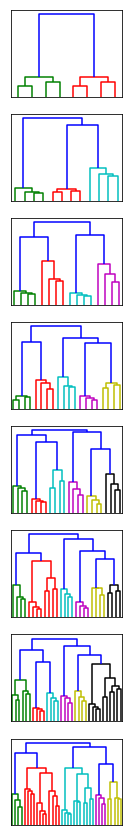

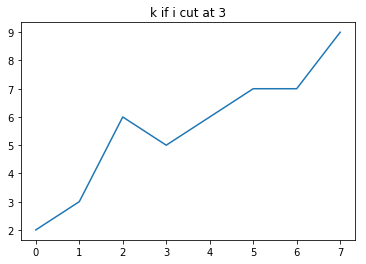

In [24]:
# step 2: create tree for each to visualize
k_trees = []
n_clus_with_cut3=np.zeros(8)
fig=plt.figure(figsize=[2,15])
for k in range(n_k):
    clustering = AgglomerativeClustering(compute_full_tree=True, distance_threshold=3, n_clusters=None,linkage='ward').fit(k_collect[k].T)
    n_clus_with_cut3[k]=len(np.unique(clustering.labels_))
    k_trees.append(clustering)
    plt.subplot(8,1,k+1)
    plot_dendrogram(clustering)
    plt.xticks([],[])
    plt.yticks([],[])
plt.show()
plt.plot(n_clus_with_cut3); plt.title('k if i cut at 3');plt.show()

# color threshold is set to 0.7*max(Z[:,2]) so 70% of the highest distance between nodes

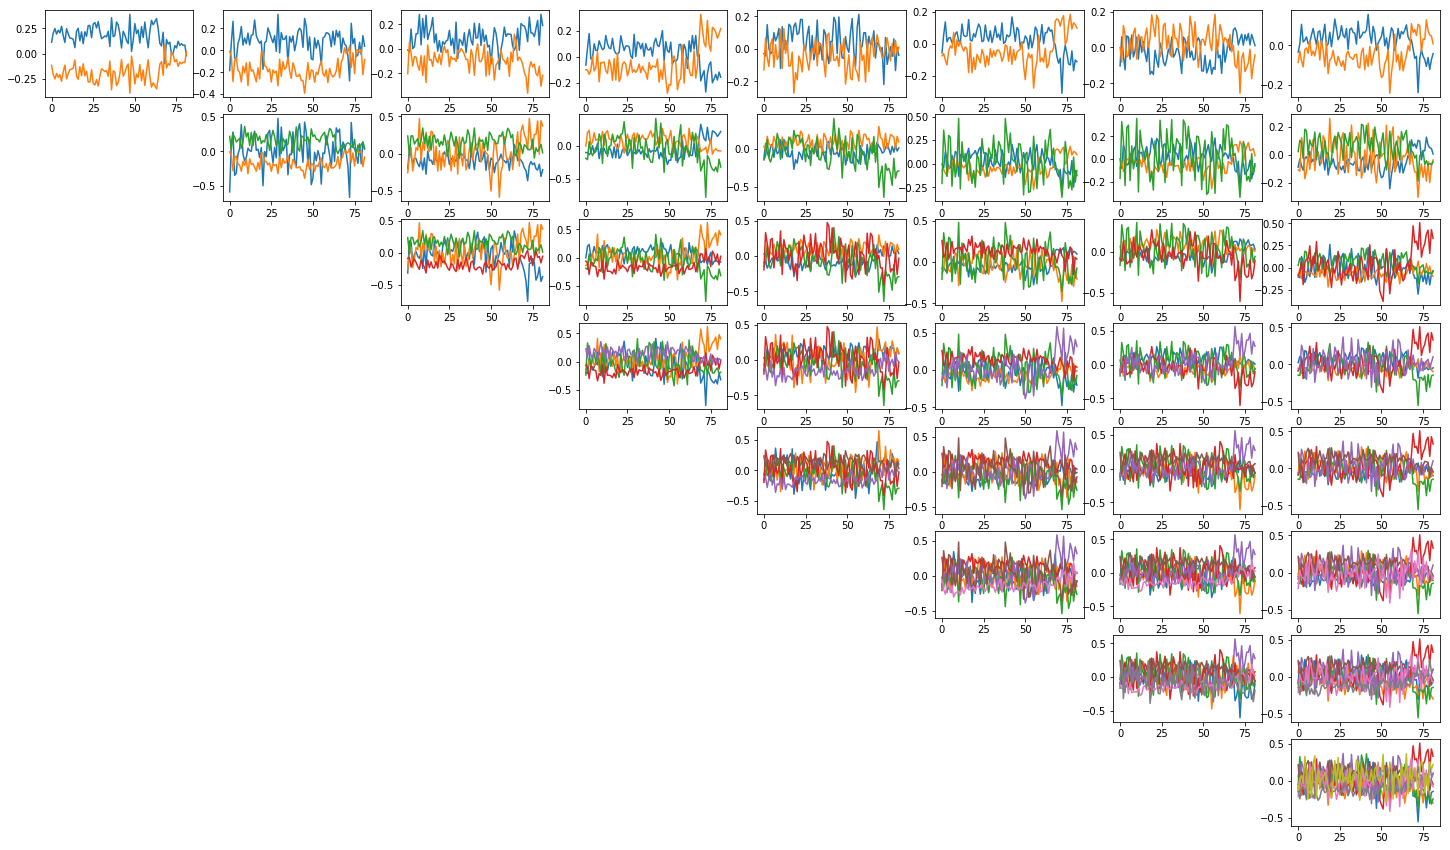

In [51]:
# step 3: force k threshold
fig=plt.figure(figsize=[25,15])
ctr=0
avgclus=[None]*n_k
for kthresh in range(n_k):
    avgclus[kthresh]=[]
    for k in range(n_k):
        ctr+=1
        if k>=kthresh:
            plt.subplot(n_k,n_k,ctr)
            clustering = AgglomerativeClustering(n_clusters=kthresh+2,linkage='ward').fit(k_collect[k].T)
            avgbs=np.full([k_collect[k].shape[0],kthresh+2],np.nan)
            for c in range(kthresh+2):
                avgbs[:,c]=np.nanmean(k_collect[k][:,np.where(clustering.labels_==c)[0]],axis=1)
            plt.plot(avgbs)
            avgclus[kthresh].append(avgbs)

/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice


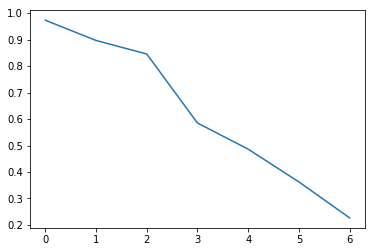

In [54]:
#step 4: calculate match between each solution
averageerror=np.zeros(n_k)
for kthresh in range(n_k):
    bestmatch = []
    for mf1 in range(len(avgclus[kthresh])):
        for mf2 in range(len(avgclus[kthresh])):
            if mf1 != mf2:
                allmses = np.full([kthresh+2,kthresh+2],np.nan)
                for c1 in range(kthresh+2):
                    for c2 in range(kthresh+2):
                        a = avgclus[kthresh][mf1][:, c1]
                        b = avgclus[kthresh][mf2][:, c2]
                        allmses[c1, c2] = vector_mse(a, b)
                for c in range(kthresh+2):
                    a=np.where(allmses==np.nanmin(allmses))
                    bestmatch.append(np.nanmin(allmses))
                    allmses[a[0][0],:]=np.nan
                    allmses[:,a[1][0]]=np.nan
    averageerror[kthresh]=np.nanmean(np.array(bestmatch))
plt.plot(averageerror)

In [3]:
# stick everything into one function and do it for all sets
def doagglomchks(s, link, input_filediri, modstri):
    
    # step 1: collect all vectors across subfolds for each k    
    mf=0
    k_collect = [None]*n_k

    for k in range(n_k):

        k_collect[k]=np.empty((setsize[s],0),int)
        for sf in range(n_cv_folds):
            fold=(mf*n_cv_folds)+sf
            filestr=(input_filediri + sets[s] + modstri + str(fold))
            with open(filestr, "rb") as f:
                mod = pickle.load(f)

            if k==0:
                crit=np.nanmean(mod.allbetas[k],axis=1)
                crit=np.array([crit,-crit]).T
                criti=np.nanmean(mod.allitcpt[k])
                criti = np.array([criti, -criti]).T
            else:
                crit=np.nanmean(mod.allbetas[k],axis=2)
                criti=np.nanmean(mod.allitcpt[k],axis=1)

            k_collect[k] = np.append(k_collect[k],crit, axis=1)

    
    # step 3: force k threshold
    avgclus=[None]*n_k
    for kthresh in range(n_k):
        avgclus[kthresh]=[]
        for k in range(n_k):
            if k>=kthresh:
                if link==0:
                    clustering = AgglomerativeClustering(n_clusters=kthresh+2,linkage='ward').fit(k_collect[k].T)
                elif link==1:
                    clustering = AgglomerativeClustering(n_clusters=kthresh+2,linkage='complete').fit(k_collect[k].T)
                elif link==2:
                    clustering = AgglomerativeClustering(n_clusters=kthresh+2,linkage='average').fit(k_collect[k].T)
                else:
                    print('please select linkage function')
                avgbs=np.full([k_collect[k].shape[0],kthresh+2],np.nan)
                for c in range(kthresh+2):
                    avgbs[:,c]=np.nanmean(k_collect[k][:,np.where(clustering.labels_==c)[0]],axis=1)
                avgclus[kthresh].append(avgbs)
                
    #step 4: calculate match between each solution
    averageerror=np.zeros(n_k)
    for kthresh in range(n_k):
        bestmatch = []
        for mf1 in range(len(avgclus[kthresh])):
            for mf2 in range(len(avgclus[kthresh])):
                if mf1 != mf2:
                    allmses = np.full([kthresh+2,kthresh+2],np.nan)
                    for c1 in range(kthresh+2):
                        for c2 in range(kthresh+2):
                            a = avgclus[kthresh][mf1][:, c1]
                            b = avgclus[kthresh][mf2][:, c2]
                            allmses[c1, c2] = vector_mse(a, b)
                    for c in range(kthresh+2):
                        a=np.where(allmses==np.nanmin(allmses))
                        bestmatch.append(np.nanmin(allmses))
                        allmses[a[0][0],:]=np.nan
                        allmses[:,a[1][0]]=np.nan
        averageerror[kthresh]=np.nanmean(np.array(bestmatch))
    return averageerror

/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/lee_jollans/anaconda3/lib/python3.7/site-

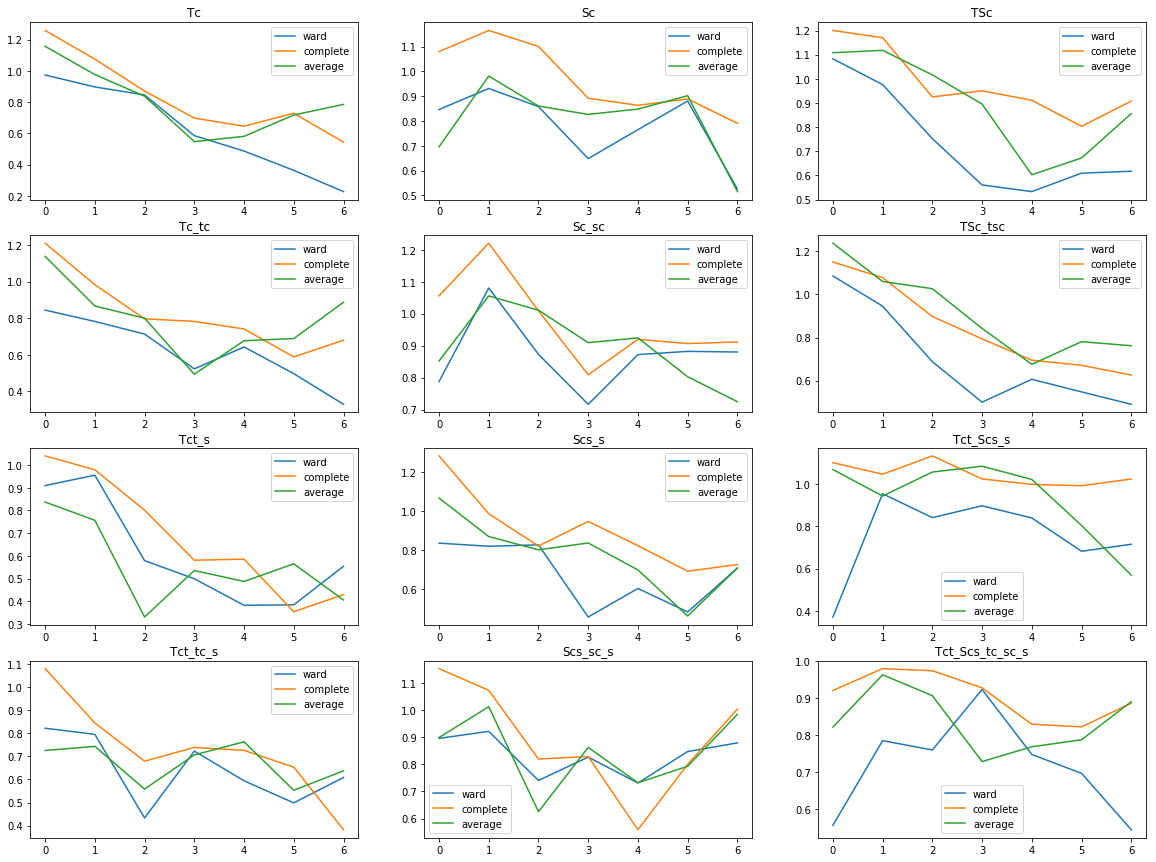

In [4]:
fig=plt.figure(figsize=[20,15])
allerrormdd=np.full([12,3,8],np.nan)
for s in range(12):
    plt.subplot(4,3,s+1)
    for link in range(3):
        averageerror=doagglomchks(s, link, input_filedir, modstr)
        allerrormdd[s,link,:]=averageerror
        plt.plot(averageerror)
    plt.legend(['ward','complete','average'])
    plt.title(sets[s])
plt.show()

/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/lee_jollans/anaconda3/lib/python3.7/site-

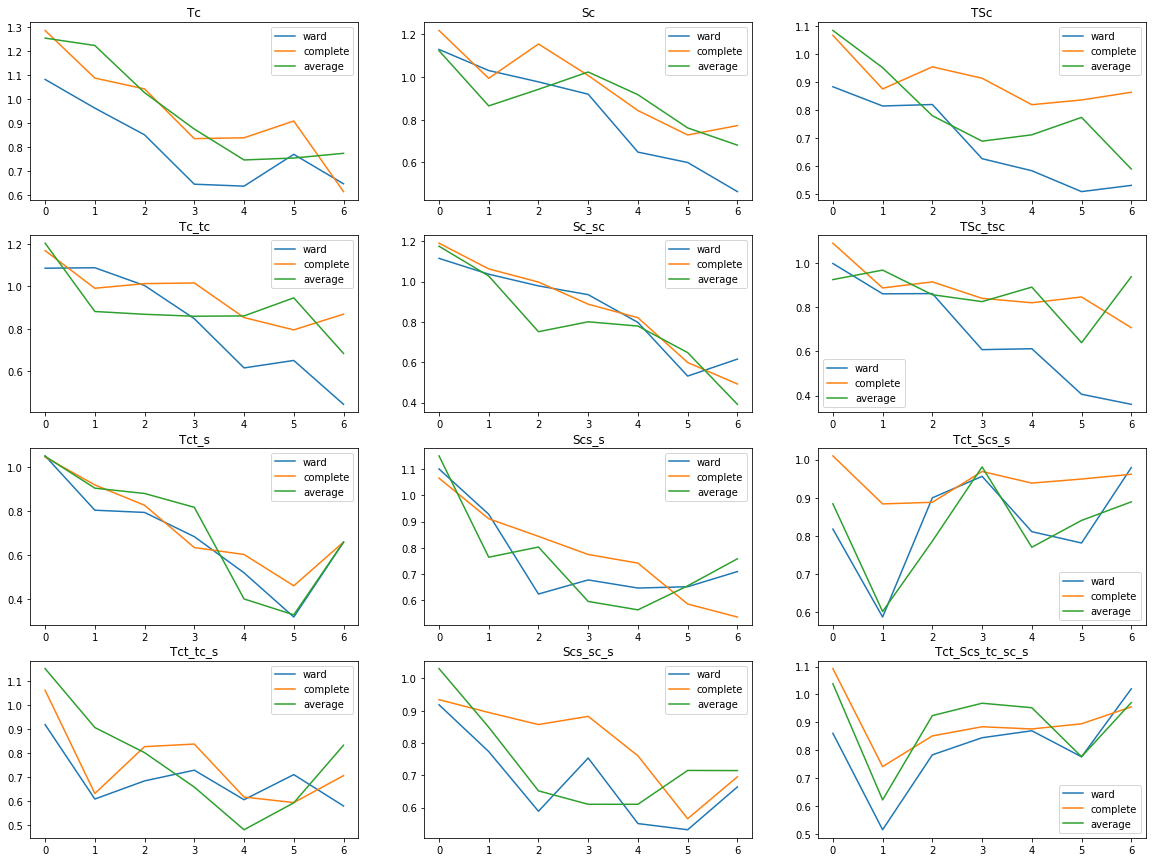

In [8]:
fig=plt.figure(figsize=[20,15])
allerrorixi=np.full([12,3,8],np.nan)
for s in range(12):
    plt.subplot(4,3,s+1)
    for link in range(3):
        averageerror=doagglomchks(s, link,input_filediri, modstri)
        allerrorixi[s,link,:]=averageerror
        plt.plot(averageerror)
    plt.legend(['ward','complete','average'])
    plt.title(sets[s])
plt.show()

/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/lee_jollans/anaconda3/lib/python3.7/site-

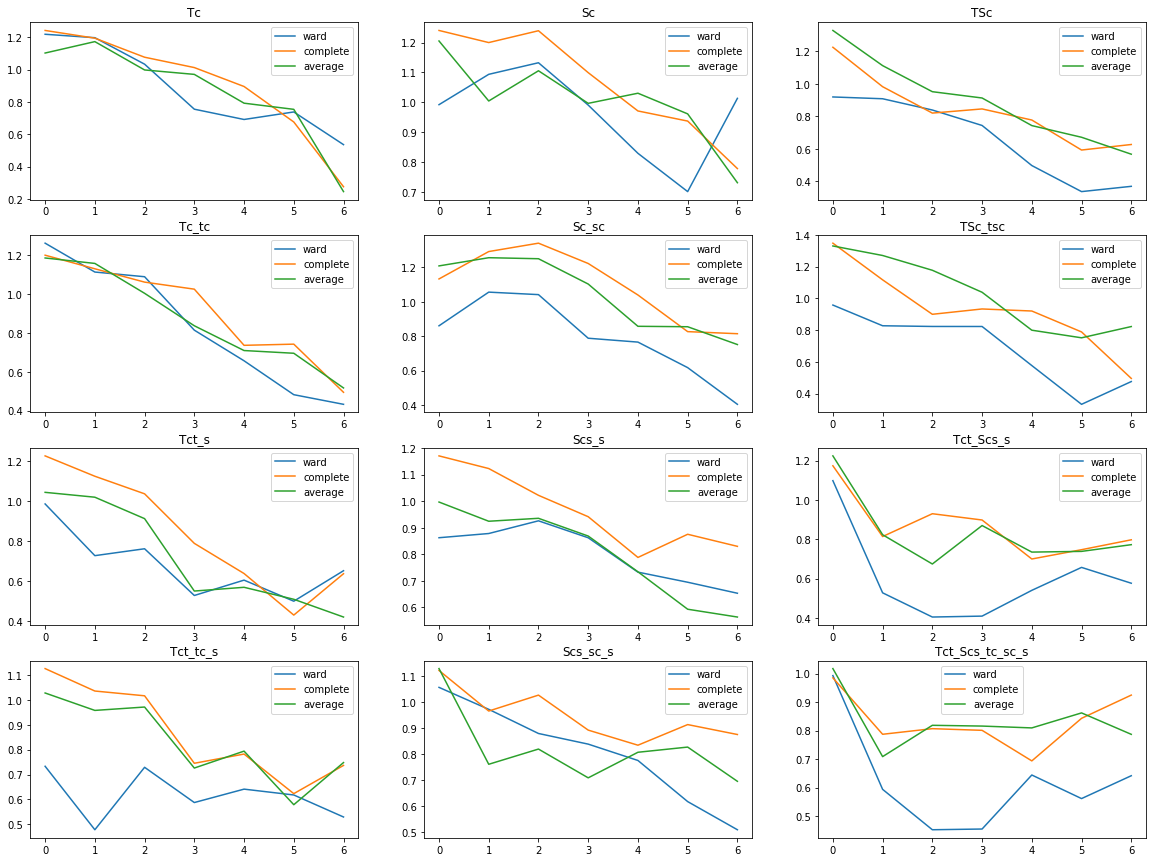

In [9]:
fig=plt.figure(figsize=[20,15])
allerrorall=np.full([12,3,8],np.nan)
for s in range(12):
    plt.subplot(4,3,s+1)
    for link in range(3):
        averageerror=doagglomchks(s, link, input_filedira, modstra)
        allerrorall[s,link,:]=averageerror
        plt.plot(averageerror)
    plt.legend(['ward','complete','average'])
    plt.title(sets[s])
plt.show()

In [10]:
#save the error matrices
with open(('/Users/lee_jollans/Projects/clustering_pilot/FEB_PUT/allerror.pkl'),'wb') as f:
    pickle.dump([allerrorall, allerrormdd, allerrorixi],f)

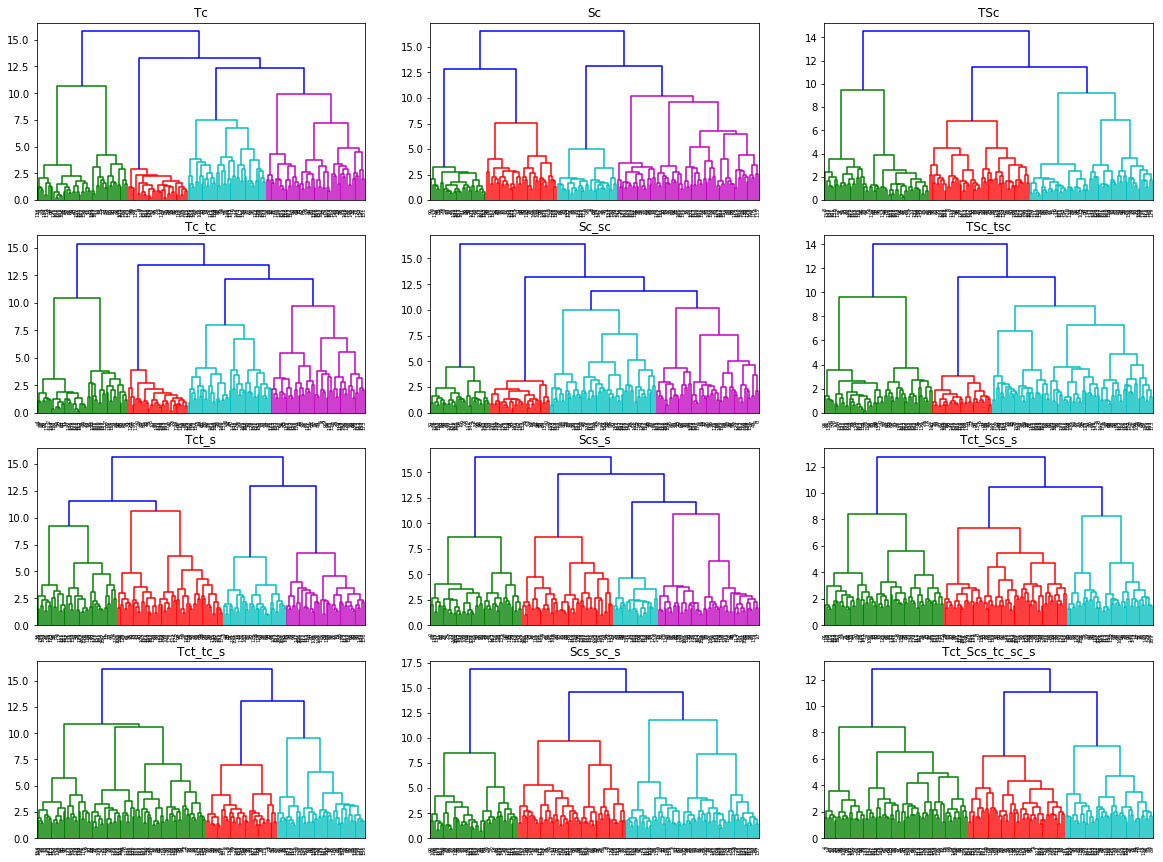

In [211]:
# also slap all vectors together and plot dendogram
mf=0
fig=plt.figure(figsize=[20,15])
for s in range(12):
    k_master_collect=np.empty((setsize[s],0),int)
    for sf in range(n_cv_folds):
        fold=(mf*n_cv_folds)+sf
        filestr=(input_filediri + sets[s] + modstri + str(fold))
        with open(filestr, "rb") as f:
            mod = pickle.load(f)
        for k in range(8):
            if k==0:
                crit=np.nanmean(mod.allbetas[k],axis=1)
                crit=np.array([crit,-crit]).T
                criti=np.nanmean(mod.allitcpt[k])
                criti = np.array([criti, -criti]).T
            else:
                crit=np.nanmean(mod.allbetas[k],axis=2)
                criti=np.nanmean(mod.allitcpt[k],axis=1)

            k_master_collect = np.append(k_master_collect,crit, axis=1)
            
    clustering = AgglomerativeClustering(compute_full_tree=True, distance_threshold=3, n_clusters=None,linkage='ward').fit(k_master_collect.T)
    plt.subplot(4,3,s+1)
    plot_dendrogram(clustering)
    plt.title(sets[s])
plt.show()

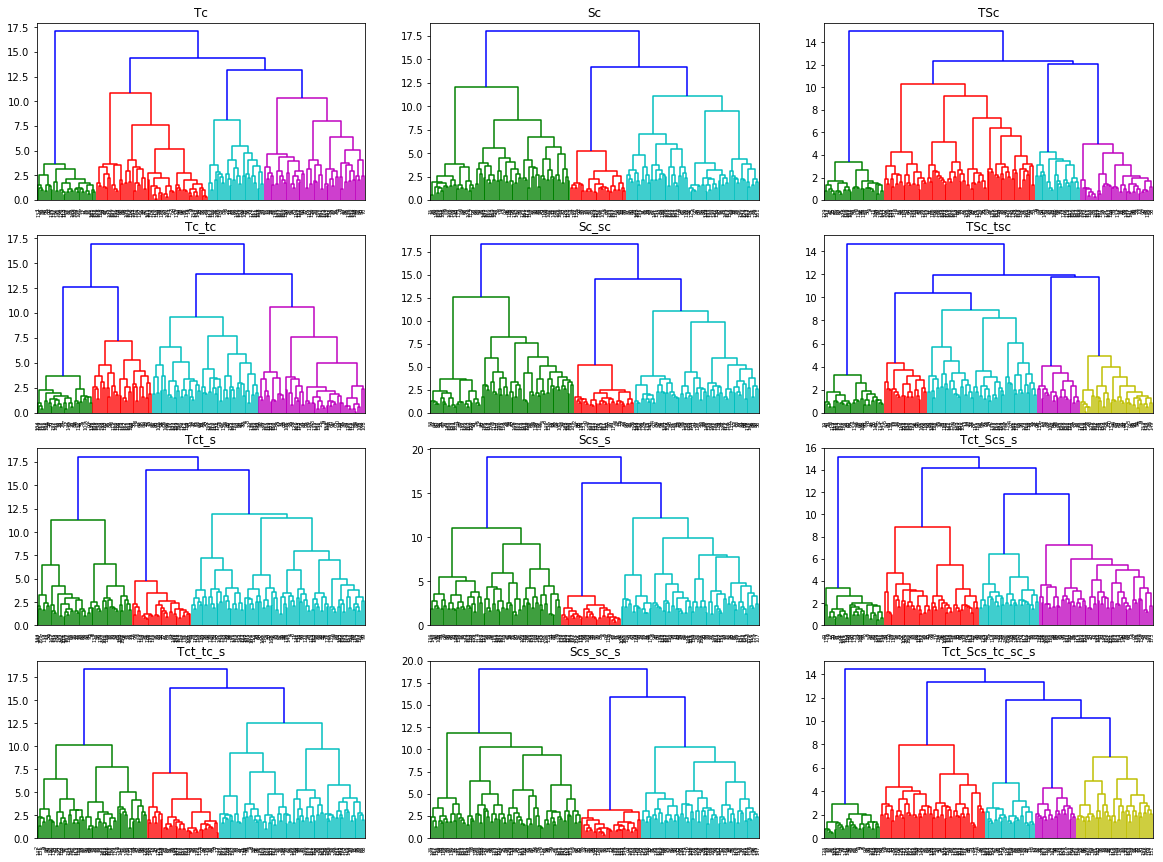

In [212]:
# also slap all vectors together and plot dendogram
mf=0
fig=plt.figure(figsize=[20,15])
for s in range(12):
    k_master_collect=np.empty((setsize[s],0),int)
    for sf in range(n_cv_folds):
        fold=(mf*n_cv_folds)+sf
        filestr=(input_filedira + sets[s] + modstra + str(fold))
        with open(filestr, "rb") as f:
            mod = pickle.load(f)
        for k in range(8):
            if k==0:
                crit=np.nanmean(mod.allbetas[k],axis=1)
                crit=np.array([crit,-crit]).T
                criti=np.nanmean(mod.allitcpt[k])
                criti = np.array([criti, -criti]).T
            else:
                crit=np.nanmean(mod.allbetas[k],axis=2)
                criti=np.nanmean(mod.allitcpt[k],axis=1)

            k_master_collect = np.append(k_master_collect,crit, axis=1)
            
    clustering = AgglomerativeClustering(compute_full_tree=True, distance_threshold=3, n_clusters=None,linkage='ward').fit(k_master_collect.T)
    plt.subplot(4,3,s+1)
    plot_dendrogram(clustering)
    plt.title(sets[s])
plt.show()

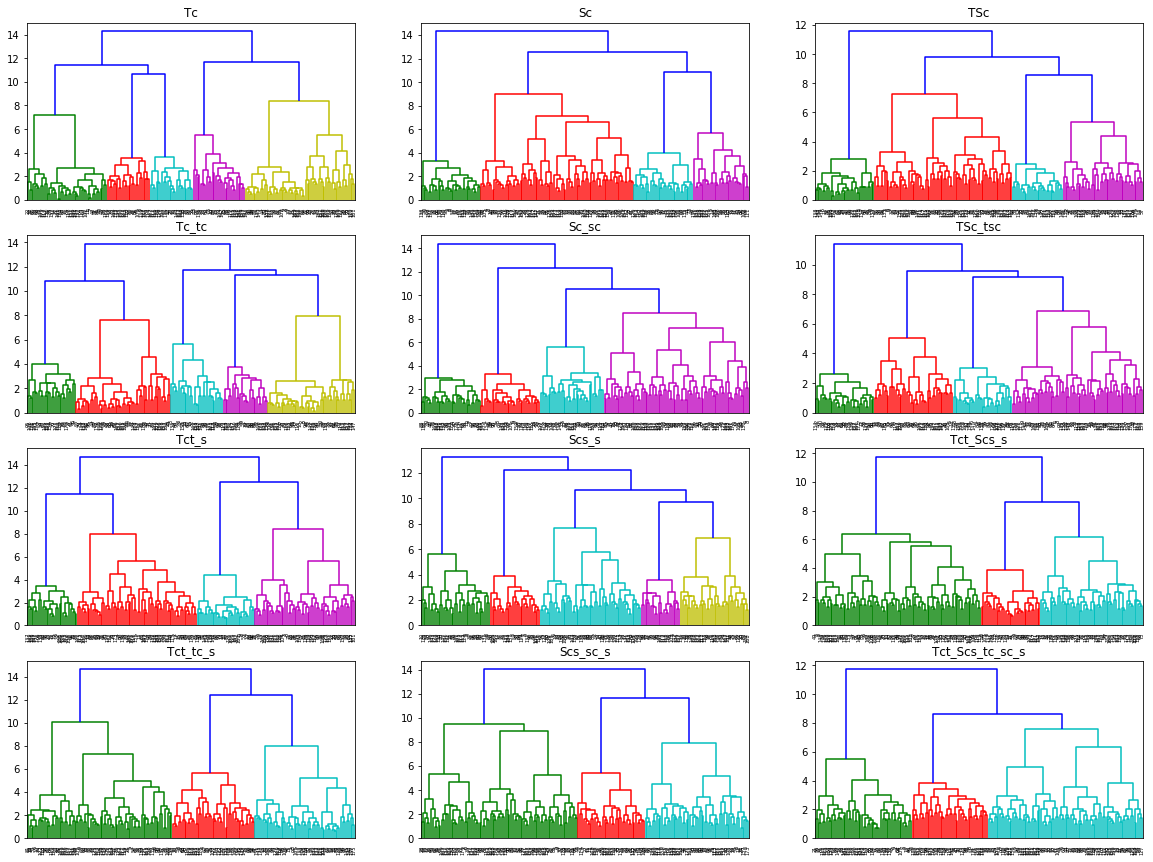

In [213]:
# also slap all vectors together and plot dendogram
mf=0
fig=plt.figure(figsize=[20,15])
for s in range(12):
    k_master_collect=np.empty((setsize[s],0),int)
    for sf in range(n_cv_folds):
        fold=(mf*n_cv_folds)+sf
        filestr=(input_filedir + sets[s] + modstr + str(fold))
        with open(filestr, "rb") as f:
            mod = pickle.load(f)
        for k in range(8):
            if k==0:
                crit=np.nanmean(mod.allbetas[k],axis=1)
                crit=np.array([crit,-crit]).T
                criti=np.nanmean(mod.allitcpt[k])
                criti = np.array([criti, -criti]).T
            else:
                crit=np.nanmean(mod.allbetas[k],axis=2)
                criti=np.nanmean(mod.allitcpt[k],axis=1)

            k_master_collect = np.append(k_master_collect,crit, axis=1)
            
    clustering = AgglomerativeClustering(compute_full_tree=True, distance_threshold=3, n_clusters=None,linkage='ward').fit(k_master_collect.T)
    plt.subplot(4,3,s+1)
    plot_dendrogram(clustering)
    plt.title(sets[s])
plt.show()

In [209]:
print(mod.allbetas[0].shape)

AttributeError: 'int' object has no attribute 'allbetas'

thickness


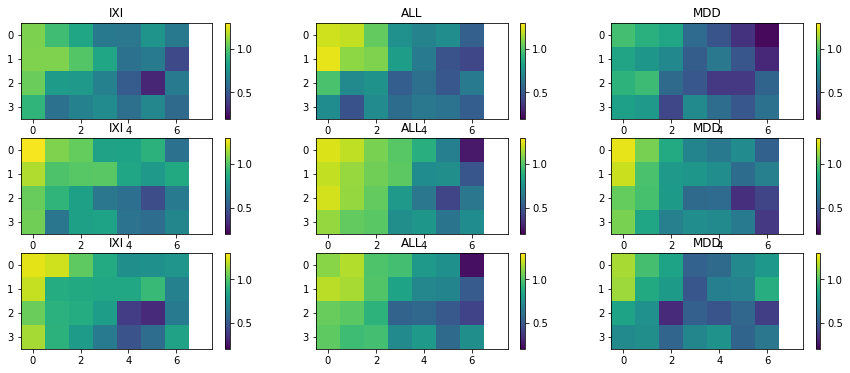

combo


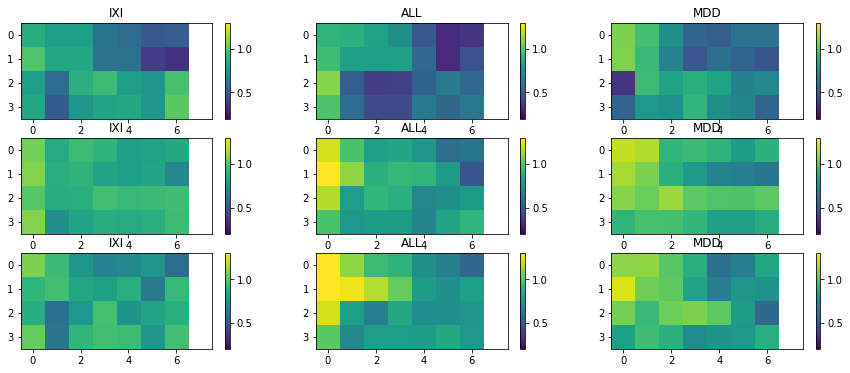

In [195]:
print('thickness')
fig=plt.figure(figsize=[15,6])
for l in range(3):
    plt.subplot(3,3,1+(3*l)); plt.title('IXI')
    plt.imshow(allerrori[[0,3,6,9],l,:]); plt.colorbar(); plt.clim(vmin=0.2, vmax=1.3)
    plt.subplot(3,3,2+(3*l)); plt.title('ALL')
    plt.imshow(allerror[[0,3,6,9],l,:]); plt.colorbar(); plt.clim(vmin=0.2, vmax=1.3)
    plt.subplot(3,3,3+(3*l)); plt.title('MDD')
    plt.imshow(allerrormdd[[0,3,6,9],l,:]); plt.colorbar(); plt.clim(vmin=0.2, vmax=1.3)
plt.show()
print('combo')
fig=plt.figure(figsize=[15,6])
for l in range(3):
    plt.subplot(3,3,1+(3*l)); plt.title('IXI')
    plt.imshow(allerrori[[2,5,8,11],l,:]); plt.colorbar(); plt.clim(vmin=0.2, vmax=1.3)
    plt.subplot(3,3,2+(3*l)); plt.title('ALL')
    plt.imshow(allerror[[2,5,8,11],l,:]); plt.colorbar(); plt.clim(vmin=0.2, vmax=1.3)
    plt.subplot(3,3,3+(3*l)); plt.title('MDD')
    plt.imshow(allerrormdd[[2,5,8,11],l,:]); plt.colorbar(); plt.clim(vmin=0.2, vmax=1.3)
plt.show()

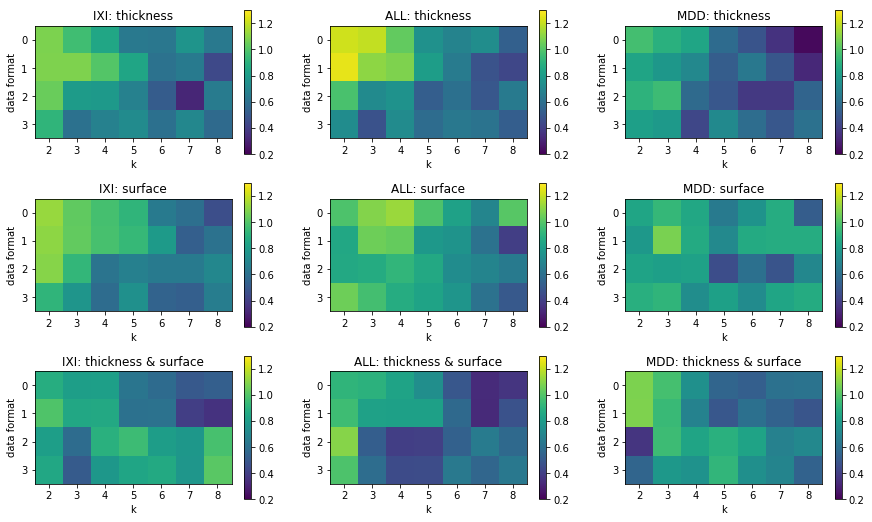

In [207]:

fig=plt.figure(figsize=[15,9])
l=0
modality=['thickness','surface','thickness & surface']
for m in range(3):
    plt.subplot(3,3,1+(3*m)); plt.title('IXI: ' + modality[m] )
    plt.imshow(allerrori[np.arange(m,12,3),l,:7]); plt.colorbar(); plt.clim(vmin=0.2, vmax=1.3)
    plt.xlabel('k'); plt.xticks(np.arange(7), np.arange(7)+2); plt.ylabel('data format')
    plt.subplot(3,3,2+(3*m)); plt.title('ALL: ' + modality[m] )
    plt.imshow(allerror[np.arange(m,12,3),l,:7]); plt.colorbar(); plt.clim(vmin=0.2, vmax=1.3)
    plt.xlabel('k'); plt.xticks(np.arange(7), np.arange(7)+2); plt.ylabel('data format')
    plt.subplot(3,3,3+(3*m)); plt.title('MDD: ' + modality[m] )
    plt.imshow(allerrormdd[np.arange(m,12,3),l,:7]); plt.colorbar(); plt.clim(vmin=0.2, vmax=1.3)
    plt.xlabel('k'); plt.xticks(np.arange(7), np.arange(7)+2); plt.ylabel('data format')
plt.show()


In [200]:
np.arange(2,12,3)

array([ 2,  5,  8, 11])

/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


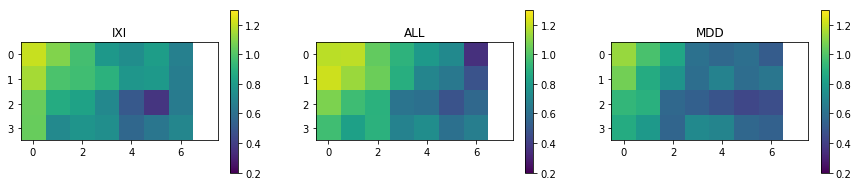

In [84]:
fig=plt.figure(figsize=[15,3])
plt.subplot(1,3,1); plt.title('IXI')
plt.imshow(np.nanmean(allerrori[[0,3,6,9],:,:],axis=1)); plt.colorbar(); plt.clim(vmin=0.2, vmax=1.3)
plt.subplot(1,3,2); plt.title('ALL')
plt.imshow(np.nanmean(allerror[[0,3,6,9],:,:],axis=1)); plt.colorbar(); plt.clim(vmin=0.2, vmax=1.3)
plt.subplot(1,3,3); plt.title('MDD')
plt.imshow(np.nanmean(allerrormdd[[0,3,6,9],:,:],axis=1)); plt.colorbar(); plt.clim(vmin=0.2, vmax=1.3)
plt.show()

In [85]:
# ALL 8 clusters
filestr=(input_filedira + sets[0] + modstra + str(fold))
with open(filestr, "rb") as f:
    mod = pickle.load(f)
tsne = TSNE(n_components=2, perplexity=30, early_exaggeration=1, learning_rate=2, n_iter=1000).fit_transform(mod.data)


In [130]:
import csv
with open('/Users/lee_jollans/Projects/clustering_pilot/ALL/ALL_samples_idx.csv', newline='') as csvfile:
    sampleidx = list(csv.reader(csvfile))
tmpsampleidx = np.array([int(sampleidx[i][0]) for i in range(len(sampleidx))])
sampleidx = np.full([740], np.nan)
sampleidx[np.where(tmpsampleidx == 1)[0]] = 4
sampleidx[np.where(tmpsampleidx == 2)[0]] = 7
sampleidx[np.where(tmpsampleidx == 3)[0]] = 5
sampleidx[np.where(tmpsampleidx == 4)[0]] = 6
sampleidx[np.where(tmpsampleidx == 5)[0]] = 1
sampleidx[np.where(tmpsampleidx == 6)[0]] = 2
sampleidx[np.where(tmpsampleidx == 7)[0]] = 3

In [98]:
def prob_from_data2(Xtrain, betas, Xtest, thr=10):
    argmaxYtrain = predictargmax(Xtrain, betas)
    tmp_trainproba, tmp_testproba = get_proba(Xtrain, argmaxYtrain, betas, Xtest)
    assignment1, likelihood1, assignment101 = assigfromproba(tmp_trainproba,thr)
    assignment2, likelihood2, assignment102 = assigfromproba(tmp_testproba, thr)
    return assignment1, likelihood1, assignment101, assignment2, likelihood2, assignment102
def predictargmax(X, betas):
    tmpX = X
    newY = tmpX.dot(betas)
    argmaxY = np.array([np.where(newY[i, :] == np.max(newY[i, :]))[0][0] for i in range(newY.shape[0])])
    return argmaxY
def assigfromproba(probs, thr=10):
    assignment = np.full([probs.shape[0]],np.nan)
    assignment10= np.full([probs.shape[0]],0)
    likelihood = np.full([probs.shape[0]],np.nan)
    for i in range(probs.shape[0]):
        crit = probs[i,:]
        if len(np.where(np.isfinite(crit))[0])>0:
            likelihood[i] = np.nanmax(crit)
            assignment[i]=np.where(crit==np.nanmax(crit))[0]+1
            # check whether the highest probability is 10% above the average given the number of classes
            avgcrit=1/probs.shape[1]
            if np.nanmax(crit)>(avgcrit+(avgcrit/thr)):
                # now check whether highest probability is 10% higher than any other
                threshval = np.nanmax(crit)-np.nanmax(crit)/thr
                if len(np.where(crit>threshval)[0])==1:
                    assignment10[i]=assignment[i]
    return assignment, likelihood, assignment10

In [183]:
s=8
filestr=(input_filedira + sets[s] + modstra + str(0))
with open(filestr, "rb") as f:
    mod = pickle.load(f)

tsne = TSNE(n_components=2, perplexity=30, early_exaggeration=1, learning_rate=2, n_iter=1000).fit_transform(mod.data)

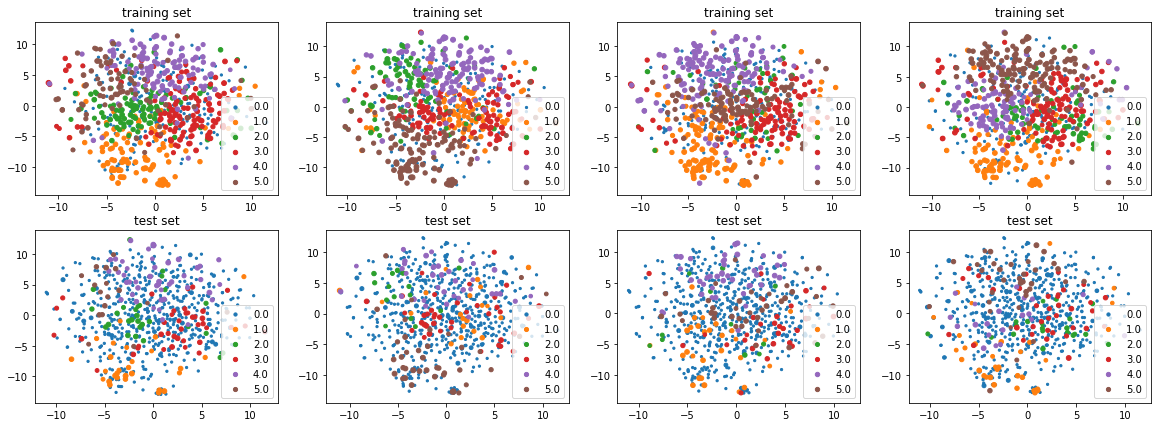

max variance explained: 0.6380127101349518


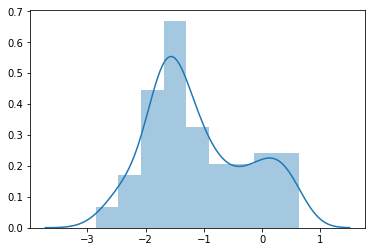

stopped because max variance under threshold
[[ 4.  5.  2.  1. nan]
 [nan nan  3.  1.  4.]
 [nan nan  2.  1. nan]
 [ 4.  3.  2.  5.  1.]]


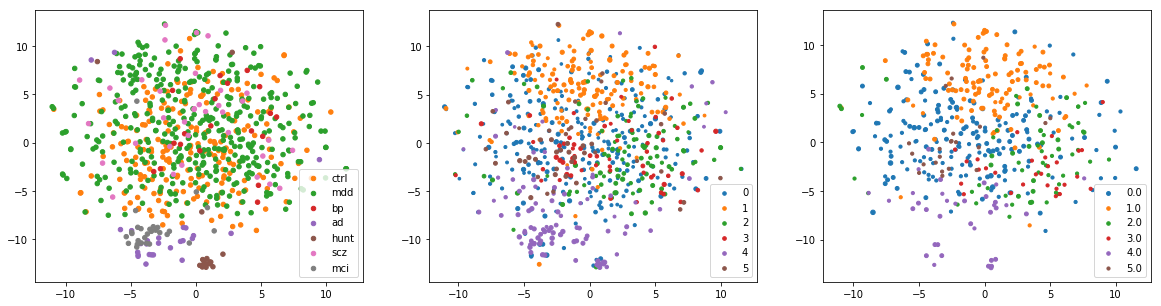

In [184]:
k=3

longliktest=np.zeros(shape=[mod.data.shape[0],4]); 
longliktrain=np.zeros(shape=[mod.data.shape[0],4]); 
longasstest=np.zeros(shape=[mod.data.shape[0],4]); 
longasstrain=np.zeros(shape=[mod.data.shape[0],4]); 

tmp=[]
fig=plt.figure(figsize=[20,7])
for mf in range(4):

    maintest = np.where(np.isnan(mod.cv_assignment[:, mf]))[0]
    maintrain = np.where(np.isfinite(mod.cv_assignment[:, mf]))[0]

    with open((input_filedira + sets[s] + '_aggr_betas_k' + str(k) + '_mf' + str(mf) + '.pkl'),'rb') as f:
        [X,clustering,assig,allbetas, tmp_testproba, argmaxYdot, argmaxYprob] = pickle.load(f)

    tmp.append(allbetas)
    assignment_train, likelihood_train, assignment10_train, assignment_test, likelihood_test, assignment10_test = prob_from_data2(mod.data[maintrain,:], allbetas, mod.data[maintest,:], 4)

    longliktest[maintest,mf]=likelihood_test; longliktrain[maintrain,mf]=likelihood_train
    longasstest[maintest,mf]=assignment10_test; longasstrain[maintrain,mf]=assignment10_train

    ax=plt.subplot(2,4,mf+1)
    colorscatter(tsne,longasstrain[:,mf],longliktrain[:,mf]*4+1,ax,1)
    plt.title('training set')
    ax=plt.subplot(2,4,mf+5)
    colorscatter(tsne,longasstest[:,mf],longliktest[:,mf]*4+1,ax,1)
    plt.title('test set')
plt.show()


allmses = np.full([4, 4, k + 2, k + 2], np.nan)
allvarexp = np.full([4, 4, k + 2, k + 2], np.nan)
allcorrs = np.full([4, 4, k + 2, k + 2], np.nan)
for mf1 in range(4):
    for mf2 in range(4):
        if mf1 < mf2:
            for c1 in range(tmp[mf1].shape[1]):
                for c2 in range(tmp[mf2].shape[1]):
                    a = tmp[mf1][:, c1]
                    b = tmp[mf2][:, c2]
                    allmses[mf1, mf2, c1, c2] = vector_mse(a, b)
                    allcorrs[mf1, mf2, c1, c2] = np.corrcoef(a, b)[0, 1] ** 2
                    ttt=(explained_variance_score(a, b) + explained_variance_score(b,a)) / 2
                    allvarexp[mf1, mf2, c1, c2] = ttt
                    allvarexp[mf2, mf1, c2, c1] = ttt
print('max variance explained:', np.nanmax(allvarexp))
sns.distplot(allvarexp.flatten())
plt.show()
assignedwhere=varexpmatcher(allvarexp, k, 1/4)

# relabel clusters in each mainfold
collected_betas=np.full([mod.data.shape[1],np.nanmax(assignedwhere).astype(int),4],np.nan)
newlabel_test = np.full([mod.data.shape[0]],0)
cert_test = np.full([mod.data.shape[0]],np.nan)
cert_train = np.full([mod.data.shape[0]],np.nan)
relabel_train = np.full([mod.data.shape[0],4],0)
newlabel_train = np.full([mod.data.shape[0]],np.nan)
for mf in range(4):
    maintest = np.where(np.isnan(mod.cv_assignment[:, mf]))[0]
    maintrain = np.where(np.isfinite(mod.cv_assignment[:, mf]))[0]
    # fill the re-labeled assignments from the test sets into one vector
    for c in range(k+2):
        if np.isfinite(assignedwhere[mf,c]):
            newlabel_test[maintest[np.where(longasstest[maintest,mf]==c+1)[0]]]=assignedwhere[mf,c]
            relabel_train[maintrain[np.where(longasstrain[maintrain,mf]==c+1)[0]],mf]=assignedwhere[mf,c]
            collected_betas[:,assignedwhere[mf,c].astype(int)-1,mf]=tmp[mf][:,c]
    cert_test[maintest]=longliktest[maintest,mf]

# for training, check consistent labelling
for i in range(mod.data.shape[0]):
    ccount=np.array([len(np.where(relabel_train[i,:]==c)[0]) for c in range(k+3)]) # here i am also counting zeros 
    # which indicates no assignment
    maxccount=np.nanmax(ccount)
    maxccountwho=np.where(ccount==maxccount)[0]
    if len(maxccountwho)==1:
        if maxccount>=2:
            newlabel_train[i]=maxccountwho
            cert_train[i]=maxccount
        else:
            cert_train[i]=4-maxccount
    else:
        cert_train[i]=4-maxccount
        
# plot
fig=plt.figure(figsize=[20,5])
ax=plt.subplot(1,3,1)
colorscatter(tsne,sampleidx,np.ones(740)*4,ax,0)
plt.legend(['ctrl', 'mdd', 'bp', 'ad', 'hunt', 'scz', 'mci'])
ax=plt.subplot(1,3,2)
colorscatter(tsne,newlabel_test,cert_test*4,ax,1)
ax=plt.subplot(1,3,3)
colorscatter(tsne,newlabel_train,cert_train,ax,1)
plt.show()

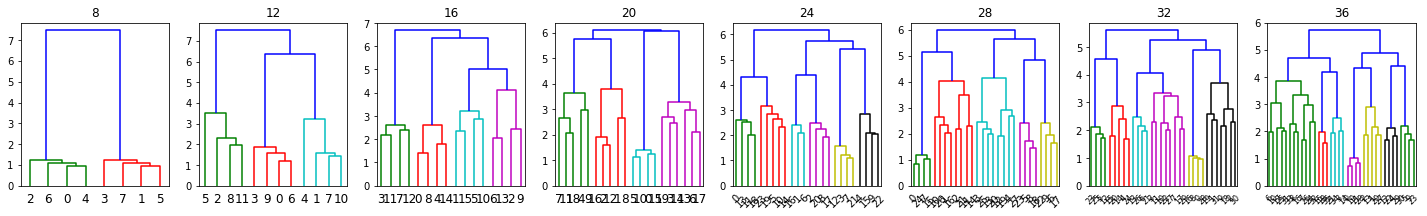

In [185]:
# here we dont retrieve hunt, so look at agglom
k_collect = [None]*n_k
s=8
mf=0
for k in range(n_k):

    k_collect[k]=np.empty((setsize[s],0),int)
    for sf in range(n_cv_folds):
        fold=(mf*n_cv_folds)+sf
        filestr=(input_filedira + sets[s] + modstra + str(fold))
        with open(filestr, "rb") as f:
            mod = pickle.load(f)

        if k==0:
            crit=np.nanmean(mod.allbetas[k],axis=1)
            crit=np.array([crit,-crit]).T
            criti=np.nanmean(mod.allitcpt[k])
            criti = np.array([criti, -criti]).T
        else:
            crit=np.nanmean(mod.allbetas[k],axis=2)
            criti=np.nanmean(mod.allitcpt[k],axis=1)

        k_collect[k] = np.append(k_collect[k],crit, axis=1)
        
k_trees = []
n_clus_with_cut3=np.zeros(8)
fig=plt.figure(figsize=[25,3])
for k in range(n_k):
    clustering = AgglomerativeClustering(compute_full_tree=True, distance_threshold=3, n_clusters=None,linkage='ward').fit(k_collect[k].T)
    n_clus_with_cut3[k]=len(np.unique(clustering.labels_))
    k_trees.append(clustering)
    plt.subplot(1,8,k+1)
    plot_dendrogram(clustering)
    plt.title(clustering.n_leaves_)
plt.show()

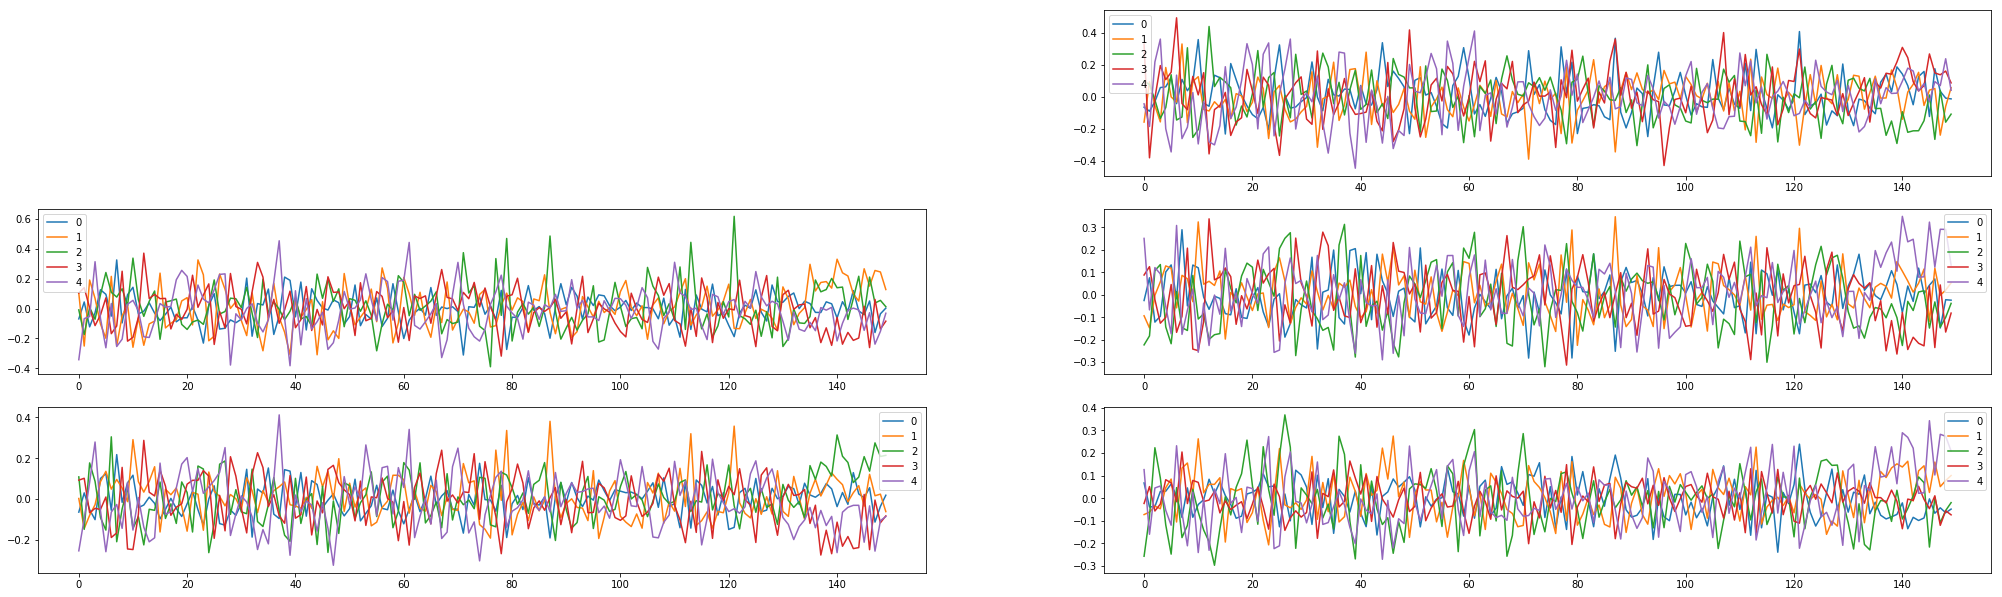

In [194]:
# step 3: force k threshold
fig=plt.figure(figsize=[35,14])
kthresh=3
avgclus=[]
for k in range(n_k):
    if k>=kthresh:
        plt.subplot(4,n_k/4,k+1)
        clustering = AgglomerativeClustering(n_clusters=kthresh+2,linkage='ward').fit(k_collect[k].T)
        avgbs=np.full([k_collect[k].shape[0],kthresh+2],np.nan)
        for c in range(kthresh+2):
            avgbs[:,c]=np.nanmean(k_collect[k][:,np.where(clustering.labels_==c)[0]],axis=1)
        plt.plot(avgbs)
        plt.legend(np.arange(kthresh+2))
        avgclus.append(avgbs)
plt.show()

In [ ]:
#step 4: calculate match between each solution
bestmatch = []

allmses = np.full([kthresh+2,kthresh+2],np.nan)
for c1 in range(kthresh+2):
    for c2 in range(kthresh+2):
        a = avgclus[0][:, c1]
        b = avgclus[1][:, c2]
        allmses[c1, c2] = vector_mse(a, b)
plt.imshow(allmses); plt.colorbar(); plt.show()

bestmatch=np.full([kthresh+2,kthresh+2],np.nan)
for c in range(kthresh+2):
    a=np.where(allmses==np.nanmin(allmses))
    print(a, np.nanmin(allmses))
    bestmatch[a[0][0],a[1][0]]=allmses[a[0][0],a[1][0]]
    allmses[a[0][0],:]=np.nan
    allmses[:,a[1][0]]=np.nan

[5, 0, 0, 0, 0, 1, 0, 0, 14]
[15, 0, 0, 0, 0, 0, 0, 1, 4]
[5, 9, 0, 0, 0, 0, 5, 0, 1]
[15, 1, 0, 0, 0, 1, 3, 0, 0]


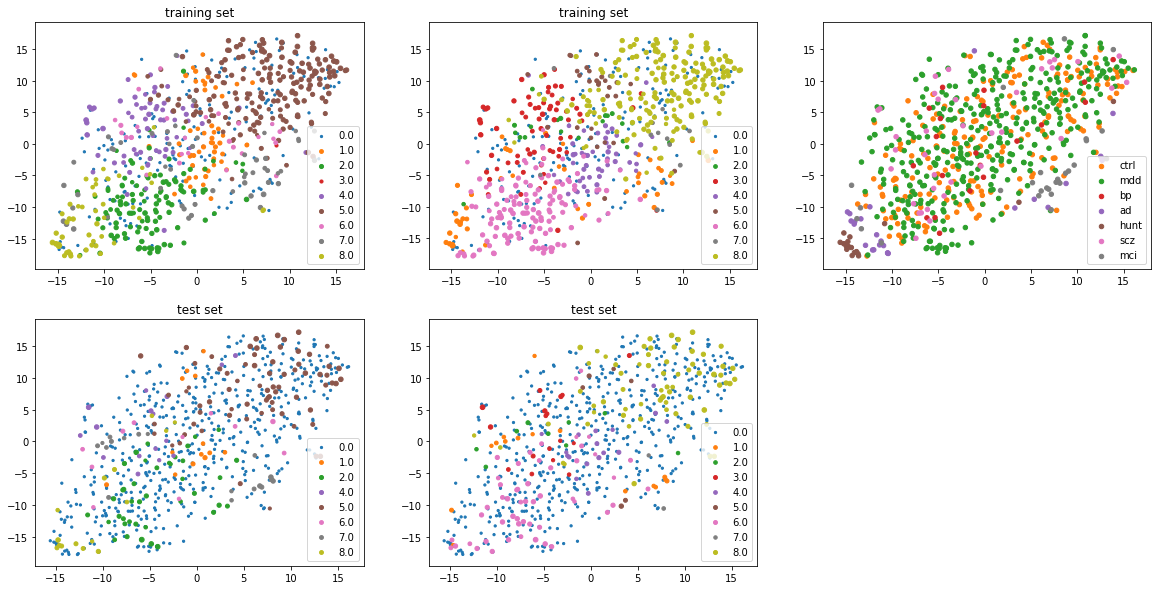

In [181]:
fig=plt.figure(figsize=[20,10])
for mf in range(2):
    assignment_train, likelihood_train, assignment10_train, assignment_test, likelihood_test, assignment10_test = prob_from_data2(mod.data[maintrain,:], avgclus[mf], mod.data[maintest,:], 4)

    longliktest=np.zeros(shape=[mod.data.shape[0]]); 
    longliktrain=np.zeros(shape=[mod.data.shape[0]]); 
    longasstest=np.zeros(shape=[mod.data.shape[0]]); 
    longasstrain=np.zeros(shape=[mod.data.shape[0]]); 
    longliktest[maintest]=likelihood_test; longliktrain[maintrain]=likelihood_train
    longasstest[maintest]=assignment_test; longasstrain[maintrain]=assignment_train

    ax=plt.subplot(2,3,mf+1)
    colorscatter(tsne,longasstrain,longliktrain*4+1,ax,1)
    plt.title('training set')
    ax=plt.subplot(2,3,mf+4)
    colorscatter(tsne,longasstest,longliktest*4+1,ax,1)
    plt.title('test set')
    print([len(np.where(longasstrain[np.where(sampleidx==5)[0]]==i)[0]) for i in range(kthresh+3)])
    print([len(np.where(longasstest[np.where(sampleidx==5)[0]]==i)[0]) for i in range(kthresh+3)])

ax=plt.subplot(2,3,3)
colorscatter(tsne,sampleidx,np.ones(740)*4,ax,0)
plt.legend(['ctrl', 'mdd', 'bp', 'ad', 'hunt', 'scz', 'mci'])
plt.show()